# LD Score Regression: Meta022 + COPD + PFT
**Author**: Jesse Marks <br>
**GitHub Issue:** [#126](https://github.com/RTIInternational/bioinformatics/issues/126) <br>
**Results Uploaded:** `s3://rti-hiv/ldsc/meta022_copd_pft/v02`


This Jupyter Notebook documents the steps taken to perform LD Score Regression (LDSC)—a tool for estimating heritability and genetic correlation—on our European-specific meta-analysis results. In particular, we perform LDSC on our in-house meta-analysis (labeled 022) compared to: the COPD GWAS results, two sets of longitudinal pulminary function test (PFT) GWAS results, and 3 cross-sectional PFT GWAS results from LDHub. We are going to utilize the [LD score regression pipeline](https://github.com/RTIInternational/ld-regression-pipeline) that Alex Waldrop developed to perform LD score regression.


___

Note that our in-house HIV acquisition meta-analysis results have A2 coded as the effect allele. LDHub expects A1 to be coded as the effect allele (see [ldsc on github](https://github.com/bulik/ldsc/wiki/Summary-Statistics-File-Format)). We will have to take this into account before we construct our file to upload to LDHub.

**workflow ID number:** <br>
`693d034b-bc31-4029-9c53-a6fab84b4532`

## Data 
* In-house HIV acquisition meta-analysis (022) (the reference phenotype)
* COPD
* 3 cross-sectional PFTs (LDHub)
* 2 longitudinal PFTs

### In-house Meta022
The 022 meta-analysis for HIV acquisition has `n=18,245` and includes:
* McLaren Eur (n=13,581)
* UHS1-4 Eur (n=3013)
* WIHS1 Eur (n=720)
* VIDUS Eur (n=931)

### COPD
* N=51772
* The inhouse COPD data. `s3://rti-nd/LDSC/COPDGWAS_HobbsEtAl/modGcNoOtherMinMissSorted.withchrpos.txt.gz`

### Three Cross-Sectional PFTs
LDHub Lung Function Studies. Note that there are new lung function results on LDHub, however they have not provided a PMID for all of the studies, therefore we cannot distinguish which data are the newest.
* Forced expiratory volume in 1 second (FEV1)
* Forced Vital capacity(FVC)
* Forced expiratory volume in 1 second (FEV1)/Forced Vital capacity(FVC)

### Two Longitudinal PFTs
These data were supplied to us by Patricia A. Cassano. They are from [the published paper a GWAS of PFT](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0100776#s5).

`s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/meta_fev1_i_all_filtered.tsv.gz` <br>
`s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/meta_fev1_i_sub.tsv.gz`

## Data Wrangling
These data need to be updated from genome build 36 to 37. We pulled these data from:  <br>
`s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/meta_fev1_i_all_filtered.tsv.gz` <br>
`s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/meta_fev1_i_sub.tsv.gz`

**Note** that we already did some processing on these data to convert them to tab separated and also to remove some random data appended to the bottom of the files.


```
snp     chr     position        allele1 allele2 freq    freqse  freq_min        freq_max        beta    se      pval    direction       hetisq  hetchisq       hetdf   hetpval
```

### update to dbSNP138

In [ ]:
# update to dbSNP138
cd /shared/jmarks/proj/hiv/ldsc/v02/processing
aws s3 cp s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/meta_fev1_i_all_filtered.tsv.gz .
aws s3 cp s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/meta_fev1_i_sub.tsv.gz .
gunzip *
    
## python3 ##
"""
Update SNP ids to dbSNP138
"""

dbsnp_file = "/shared/common/snp_id_conversion/b138/old_to_current.xref"
infile = "/shared/jmarks/proj/hiv/ldsc/v02/processing/meta_fev1_i_sub.tsv"
outfile =  "/shared/jmarks/proj/hiv/ldsc/v02/processing/pft_longitudinal_build37_sub.tsv"
#infile = "/shared/jmarks/proj/hiv/ldsc/v02/processing/meta_fev1_i_all_filtered.tsv"
#outfile =  "/shared/jmarks/proj/hiv/ldsc/v02/processing/pft_longitudinal_build37_all.tsv"

with open(infile) as inF, open(dbsnp_file) as dbF, open(outfile, "w") as outF:
    head = inF.readline()
    outF.write(head)

    db_head = dbF.readline()
    db_line = dbF.readline()
    db_dict = {}
    while db_line:
        sl = db_line.split()
        db_dict[sl[0]] = sl[1]
        db_line = dbF.readline()

    line = inF.readline()
    while line:
        sl = line.split()
        if sl[0] in db_dict.keys():
            sl[0] = db_dict[sl[0]]
            newline = "\t".join(sl)
            outF.write(newline + "\n")
        else:
            newline = "\t".join(sl)
            outF.write(newline + "\n")

        line = inF.readline()

### update to genome build 37

In [ ]:
## python3 ##
"""
update to GRCh37
""" 
update37 = "/shared/common/build_conversion/b37/dbsnp_b138/uniquely_mapped_snps.id_chr_pos"

#infile =  "/shared/jmarks/proj/hiv/ldsc/v02/processing/pft_longitudinal_build37_sub.tsv"
#outfile =  "/shared/jmarks/proj/hiv/ldsc/v02/processing/pft_longitudinal_build37_sub_chr.tsv"
infile =  "/shared/jmarks/proj/hiv/ldsc/v02/processing/pft_longitudinal_build37_all.tsv"
outfile =  "/shared/jmarks/proj/hiv/ldsc/v02/processing/pft_longitudinal_build37_all_chr.tsv"

with open(infile) as inF, open(update37) as upF, open(outfile, "w") as outF:
    head = inF.readline()
    outF.write(head)

    up_line = upF.readline()
    up_dict = {}
    n = 0
    while up_line:
        sl = up_line.split()
        up_dict[sl[0]] = [sl[1], sl[2]]
        up_line = upF.readline()
        n += 1

    line = inF.readline()
    while line:
        sl = line.split()
        if sl[0] in up_dict.keys():
            sl[1] = up_dict[sl[0]][0]   # chr
            sl[2] = up_dict[sl[0]][1]   # pos
            newline = "\t".join(sl)
            outF.write(newline + "\n")
        else:
            pass
        line = inF.readline()
        n += 1

In [ ]:
# rename files
mv /shared/jmarks/proj/hiv/ldsc/v02/processing/pft_longitudinal_build37_all_chr.tsv \
    /shared/jmarks/proj/hiv/ldsc/v02/processing/pft_longitudinal_build37_all.tsv
mv /shared/jmarks/proj/hiv/ldsc/v02/processing/pft_longitudinal_build37_sub_chr.tsv \
    /shared/jmarks/proj/hiv/ldsc/v02/processing/pft_longitudinal_build37_sub.tsv

# compress
gzip pft*

# upload 
for file in pft*; do
    aws s3 cp $file s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/$file
done

## Create WorkFlow inputs
**Workflow guideline:**
1. Create Excel phenotype file locally then upload to EC2 instance
2. Clone https://github.com/RTIInternational/ld-regression-pipeline
3. Then edit full_ld_regression_wf_template.json to include the reference data of choice
4. Use dockerized tool to finish filling out the json file that will be input for workflow
5. Perform LDSC using the WDL workflow
   - If necessary, get results from LDHub
   - Merge data Create final plots with dockerized tool 
 
<br><br>

Here is an example entry in the Excel Phenotype File:

**trait	plot_label	sumstats_path	pmid	category	sample_size	id_col	chr_col	pos_col	effect_allele_col	ref_allele_col	effect_col	pvalue_col	sample_size_col	effect_type	w_ld_chr**
```
COPDGWAS Hobbs et al.	COPD	s3://rti-nd/LDSC/COPDGWAS_HobbsEtAl/modGcNoOtherMinMissSorted.withchrpos.txt.gz	28166215	Respiratory	51772	3	1	2	4	5	10	12		beta	s3://clustername--files/eur_w_ld_chr.tar.bz2
```

**Note** that the GWAS results at `sumstats_path` need to be tab separated.

In [ ]:
### EC2 ###

# clone github repo
cd /shared/jmarks/proj/hiv/ldsc/v02
git clone https://github.com/RTIInternational/ld-regression-pipeline
    
# edit file-input json
cd ld-regression-pipeline
mkdir workflow_inputs
cp json_input/full_ld_regression_wf_template.json workflow_inputs
cd workflow_inputs

## vim edit full*json file (see README.md at https://github.com/RTIInternational/ld-regression-pipeline)

In [ ]:
### local ###

## edit phenotype file and upload to EC2 instance
cd /home/jmarks/Projects/HIV/ldsc/meta022_copd_lung_function/v02/processing/cromwell/input
scp -i ~/.ssh/gwas_rsa *xlsx ec2-user@54.84.72.140:/shared/jmarks/proj/hiv/ldsc/v02/ld-regression-pipeline/workflow_inputs

In [ ]:
### EC2 ###

# create final workflow input (a json file)
docker run -v /shared/jmarks/proj/hiv/ldsc/v02/ld-regression-pipeline/workflow_inputs:/data/ \
    rticode/generate_ld_regression_input_json:1ddbd682cb1e44dab6d11ee571add34bd1d06e21 \
    --json-input /data/full_ld_regression_wf_template.json \
    --pheno-file /data/20190924_hiv_ldsc_phenotypes_local.xlsx >\
        /shared/jmarks/proj/hiv/ldsc/v02/ld-regression-pipeline/workflow_inputs/final_wf_inputs.json

## Run Analysis Workflow

In [ ]:
# use screen tool and enter compute node
screen 
qrsh -l h=ip-172-31-29-161

## zip appropriate files 
# Change to directory immediately above ld-regression-pipeline
cd /shared/jmarks/proj/hiv/ldsc/v02/ld-regression-pipeline
cd ..
# Make zipped copy of repo somewhere
zip --exclude=*var/* --exclude=*.git/* -r \
    /shared/jmarks/proj/hiv/ldsc/v02/ld-regression-pipeline/workflow_inputs/ld-regression-pipeline.zip \
    ld-regression-pipeline

## download cromwell and the config file, if necessary
cd /shared/jmarks/bin/cromwell
#aws s3 cp s3://rti-cromwell-output/cromwell-config/cromwell_default_genomics_queue.conf .
#wget https://github.com/broadinstitute/cromwell/releases/download/44/cromwell-44.jar

## run ldsc workflow on AWS EC2 instance
java -Dconfig.file=/shared/jmarks/bin/cromwell/cromwell_default_genomics_queue.conf \
    -jar cromwell-44.jar \
    run /shared/jmarks/proj/hiv/ldsc/v02/ld-regression-pipeline/workflow/full_ld_regression_wf.wdl \
    -i /shared/jmarks/proj/hiv/ldsc/v02/ld-regression-pipeline/workflow_inputs/final_wf_inputs.json \
    -p /shared/jmarks/proj/hiv/ldsc/v02/ld-regression-pipeline/workflow_inputs/ld-regression-pipeline.zip

### copy workflow ID
You will need this to find the results on S3 at `rti-cromwell-output/cromwell-execution/full_ld_regression_wf/<id-number>`

Get this ID by looking at the log, example: <br>
`/shared/jmarks/bin/cromwell/cromwell-workflow-logs/workflow.cffd947c-9345-41f1-a146-3e3454404fa3.log`

### Copy Workflow Results to Local

In [ ]:
cd /home/jmarks/Projects/HIV/ldsc/meta022_copd_pft/v02/processing/input/cromwell
scp -i ~/.ssh/gwas_rsa   ec2-user@54.84.72.140:/shared/jmarks/proj/hiv/ldsc/v02/ld-regression-pipeline/workflow_inputs/* .

cd /home/jmarks/Projects/HIV/ldsc/meta022_copd_pft/v02/processing/output/cromwell
#aws s3 cp s3://rti-hiv/ldsc/20190923_meta022v3_copd_lung_function/cromwell_output/call-plot_ld/PLOT.plot_ld_regression_wf/045969b0-44b6-404e-a280-167c9ae912be/call-make_plot_table/hiv_acq_meta022v3_vs_copd.ld_regression_results.tsv . 

## [LD Hub](http://ldsc.broadinstitute.org/ldhub/)
```
Important notes for your uploaded file:

1. To save the uploading time, LD Hub only accepts zipped files as input (e.g. mydata.zip).

2. Please check that there is ONLY ONE plain TXT file (e.g. mydata.txt) in your zipped file.

3. Please make sure you do NOT zip any folder together with the plain txt file (e.g. /myfolder/mydata.txt), otherwise you will get an error: [Errno 2] No such file or directory

4. Please do NOT zip multiple files (e.g. zip mydata.zip file1.txt file2.txt ..) or zip a file with in a folder (e.g. zip mydata.zip /path/to/my/file/mydata.txt).

5. Please keep the file name of your plain txt file short (less than 50 characters), otherwise you may get an error: [Errno 2] No such file or directory

6. Please zip your plain txt file using following command (ONE file at a time):

For Windows system: 1) Locate the file that you want to compress. 2) Right-click the file, point to Send to, and then click Compressed (zipped) folder.

For Linux and Mac OS system: zip mydata.zip mydata.txt

Reminder: for Mac OS system, please do NOT zip you file by right click mouse and click "Compress" to zip your file, this will automatically create a folder called "__MACOS". You will get an error: [Errno 2] No such file or directory.

Upload the trait of interest
To save your upload time, we highly recommend you to use the SNP list we used in LD Hub to reduce the number of SNPs in your uploaded file. Click here to download our SNP list (w_hm3.noMHC.snplist.zip).

Please upload the zipped file you just created. Click here to download an input example.
```



### create input file 

The input file is created during the WDL workflow we ran above. LDHub requires the input data to be in a certain format, so there will be some minimal processing to do before we upload the reference phenotype file.

**Note**: Here we have switched the A1 and A2 around because LDHub expects A1 to be the effect allele. Our results have A2 as the effect allele.

In [ ]:
### Download outputs for each ref chr from rftm_sumstats step ###

#cd /shared/jmarks/proj/hiv/ldsc/v02/ldhub
#aws s3 sync  s3://rti-hiv/ldsc/meta022_copd_pft/v04/output/cromwell/80d9cb63-b831-453c-928e-b590b69198ed/call-munge_ref/MUNGE_REF_WF.munge_sumstats_wf/828b701e-8651-4794-925a-e24aa378d68f/call-munge_chr_wf/ .
#           # s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/cad01742-2337-4c14-9f40-7b1e9965fddf/call-munge_ref/MUNGE_REF_WF.munge_sumstats_wf/7269da15-a598-4148-a255-0017f7d0dda3/call-munge_chr_wf/ .
#        
#mv  */MUNGE_CHR.munge_sumstats_chr_wf/*/call-rfmt_sumstats/hiv_acquisition_ea_specific_1df_meta_analysis_mclaren_ea+meta016_gc_applied_twice_exclude_singletons.chr*.standardized.phase3ID.munge_ready.txt .
#
### Concat into single file ##
#cat hiv_acquisition_ea_specific_1df_meta_analysis_mclaren_ea+meta016_gc_applied_twice_exclude_singletons.chr1.standardized.phase3ID.munge_ready.txt >\
#    hiv022_ldhub_with_pvalues.txt
#for chr in {2..22}
#do
#    tail -n +2  hiv_acquisition_ea_specific_1df_meta_analysis_mclaren_ea+meta016_gc_applied_twice_exclude_singletons.chr$chr.standardized.phase3ID.munge_ready.txt >>\
#        hiv022_ldhub_with_pvalues.txt
#done
##cp hiv022_ldhub_with_pvalues.txt hiv_munge.txt
#
#
### Remove unnecessary columns (need snpID, A1, A2 Beta, Pvalue) in that order ##
#head -1 hiv022_ldub_with_pvalues.txt | cut -f1,4,5,6,7 > tmp
#tail -n +2 hiv022_ldhub_with_pvalues.txt | awk 'BEGIN{OFS="\t"}{print $1, $4, $5, $6, $7}'  >>\
#    tmp && mv tmp hiv022_ldhub_with_pvalues.txt
#
#
### Add sample size column (sample = 18245.00) and change header names ##
#cat hiv022_ldhub_with_pvalues.txt |\
#    awk -v OFS="\t" -F"\t" 'NR==1{print "snpid", "A1", "A2", "BETA", "N", "P-value"} 
#    NR>1{print $1,$2,$3,$4,"18245.00", $5}' > \
#    tmp && mv tmp hiv022_ldhub_with_pvalues.txt

In [ ]:
cd /home/jmarks/Projects/HIV/ldsc/meta022_copd_pft/v02/processing/ldhub/input 
scp -i ~/.ssh/gwas_rsa   ec2-user@54.84.72.140:/shared/jmarks/proj/hiv/ldsc/v02/ldhub/hiv022_ldhub_with_pvalues.txt
    
# zip file with 7zip
hiv022_ldhub_with_pvalues.txt.zip

### upload input file
Follow the steps above to zip and upload input file. Essentially, 
* download the file created in the cell above to your local machine.
* Then zip this file (and only this file).
* Login to [LDHub](http://ldsc.broadinstitute.org/ldhub/) by clicking on `Get Started with LDHub` and then sign in with your Google email account.
* Click `Go Test Center`
* Click `Continue`
* Upload zipped file by clicking `Choose File`, naming your trait, and clicking `Continue`.
* Select traits of interest from LDHub by checking the box next to the trait of interest and then clicking `Submit your request`

**Note**: keep browser open during LDSC analysis on LDHub.

`hiv`

### download LDHub output
You should see the following message after uploading your data:
```
Analysis in progress ...
1) Please keep the browser open when uploading your file.

2) The webpage will jump to the results page automatically after the QC and H2 analysis was done.

3) The rg analysis will keep running in the backend. Each rg test may take about 20 seconds. A rg analysis of all traits may take up to five hours.
```

After this page, you will see the results page with the download ready once the anaylsis has finished.

## Create Final Plot
This is needed if there were additional phenotypes used from LDHub. If no phenotypes from LDHub were included, then the we need plot was already created during the WDL workflow. For example, you can find the plot in the following location:

`s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/cad01742-2337-4c14-9f40-7b1e9965fddf/call-plot_ld/PLOT.plot_ld_regression_wf/045969b0-44b6-404e-a280-167c9ae912be/call-plot_ld_regression_results/hiv_acq_meta022v3_vs_copd.ld_regression_results.pdf`

We need to create a CSV file with the results that we want to plot. We will need to merge the results from the cromwell WDL workflow with the LDHub results. The easiest way to do this is to create an Excel spreadsheet with three different sheets. One sheet will be the output from LDHub that we downloaded earlier, the results from the cromwell WDL workflow, and then a sheet that contains the merged results. The cromwell workflow results can be found in the `cromwell_output/call-plot_ld/` folder. For example, `s3://rti-hiv/ldsc/20190911_meta022v3_copd_lung_function/cromwell_output/call-plot_ld/PLOT.plot_ld_regression_wf/045969b0-44b6-404e-a280-167c9ae912be/call-make_plot_table/hiv_acq_meta022v3_vs_copd.ld_regression_results.tsv`. 

The merged CSV file should have the header:
```
trait2	Trait_Label	Trait_Group	rg	se	z	p	h2_obs	h2_obs_se	h2_int	h2_int_se	gcov_int	gcov_int_se
```

For an example file, see: <br>
`s3://rti-hiv/ldsc/20190911_meta022v3_copd_lung_function/final/20190911_hivacq_ldsc_meta022v3_vs_COPD_and_ldhub_lung_function_results_table.csv`

**Note**: I had to upload my results table to an EC2 instance in order to run the next cell which creates the plot of the merged results.

In [ ]:
## enter interactive mode ##
# note that the image tag corresponds to the latest tag for this image
docker run -it -v"/shared/jmarks/proj/hiv/ldsc/meta022/v02/plot:/data/" \
    rticode/plot_ld_regression_results:7bbd11a1d0c664bcb8bede8c398772b13abe15b3  /bin/bash
    
Rscript /opt/plot_ld_regression/plot_ld_regression_results.R  \
    --input_file 20190924_hivacq_ldsc_meta022_copd_pft_rg_results.csv \
    --output_file 20190924_hivacq_ldsc_meta022_copd_pft_rg_results.pdf  \
    --comma_delimited \
    --title "HIV Acquisition Meta022 (With McLaren)"

## Copy results to correct S3 bucket
The results of all of the analyses for LDSC using the WDL workflow are saved automatically in an S3 folder:<br>
`s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/<id-number>`

We will need to copy these results over to the correct S3 bucket corresponding to the project it was for. <br>
**Note** be sure to upload a README file that explains the analysis.

___

<br><br>

Below is the README.txt file uploaded to that bucket too:

```
Author: Jesse Marks
Date: 20190917
GitHub Issue: 126

This LDSC analysis is using the reference phenotype meta022, which is
a meta-analysis for HIV acquisition and contains the samples:
McLaren EA (n=13,581)
UHS1-4 EA (n=3013)
WIHS1 EA (n=720)
VIDUS EA (n=931)

We will compare this reference phenotype to:
COPD
3 Lung Function Cohorts in LDHub (PMID 28166213)
    -Forced expiratory volumne in 1 second (FEV1)
    -Forece Vital capacity (FVC)
    -Forece expiratory volumne in 1 second (FEV1)/Foreced Vital capacity(FVC)
2 pulminary lung function results we have in-house.
    -s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/MAres_FEV1_Longitudinal_All_291120121.tbl
    -s3://rti-shares/gxg/R21_GxNutrients/PriorGWASresults/MAres_FEV1_Longitudinal_sub_291120121.tbl

Note about the 2 pulminary lung function cohorts:
    -The "all" (MAres_FEV1_Longitudinal_All_291120121.tbl) was anyone with any decline (any measurement, phenotype not as good)
    -The "sub" (MAres_FEV1_Longitudinal_sub_291120121.tbl) was more restrictive and kept only participants with optimum measurements (every three years) so this is a smaller N (had one sig finding but no replication) (cleaner phenotype)


###############################################################################################################################
Update: we did not include the 2 pulminary lung function results in this analysis. We were having issues with the format of the data. In particular, the data seemed to be a interspered with binary format -- almost like the data were not successfully, only partially, converted to text files.

Update2:  After finishing this LDSC analysis, we realized that our results were flipped when comparing to LDHub. This is because our results are coded such that A2 is the effect allele and LDHub expects A1 to be the effect allele. We fix this by flipping the sign for the genetic correlation (rg) for the traits recieve from LDHub in the final plot-file.


###############################################################################################################################

v03 is with the meta-analysis results at s3://rti-hiv/meta_new/022/results/v03/stats/final
v04 is with the meta-analysis results at s3://rti-hiv/meta_new/022/results/v04/stats/final

The version 4 results are a cleaner set of results; McLaren SNP filters were applied to remove
SNPs with MAF < 1%, RSQ < 0.8, and any SNP not available in all samples of the McLaren meta.

```
**Note** We will also copy the input files and the plot we created to the S3 bucket.

In [ ]:
cd /home/jmarks/Projects/HIV/ldsc/20190917_meta022v3_copd_lung_function/cromwell_input
aws s3 sync . s3://rti-hiv/ldsc/20190917_meta022v3_copd_lung_function/cromwell_input/
    
cd /home/jmarks/Projects/HIV/ldsc/20190917_meta022v3_copd_lung_function/final
aws s3 sync . s3://rti-hiv/ldsc/20190917_meta022v3_copd_lung_function/final/

cd /home/jmarks/Projects/HIV/ldsc/20190917_meta022v3_copd_lung_function
aws s3 cp README.txt s3://rti-hiv/ldsc/20190917_meta022v3_copd_lung_function/README.txt

# LDSC: meta022 + COPD
**Author**: Jesse Marks <br>
**GitHub Issue:** [#126](https://github.com/RTIInternational/bioinformatics/issues/126) <br>
**Results Uploaded:** `s3://rti-hiv/ldsc/meta022_copd_pft/v01`


This section is without the 2 longitudinal PFT studies included.

___

Note that our in-house HIV acquisition meta-analysis results have A2 coded as the effect allele. LDHub expects A1 to be coded as the effect allele (see [ldsc on github](https://github.com/bulik/ldsc/wiki/Summary-Statistics-File-Format)). We will have to take this into account before we construct our file to upload to LDHub.

**workflow ID number:** <br>
`f6d05bbe-3393-448a-9c5f-db15fac56d4c`

In [ ]:
### EC2 ###

# clone github repo
cd /shared/jmarks/proj/hiv/ldsc/v01
git clone https://github.com/RTIInternational/ld-regression-pipeline
    
# edit file-input json
cd ld-regression-pipeline
mkdir workflow_inputs
cp json_input/full_ld_regression_wf_template.json workflow_inputs
cd workflow_inputs

## vim edit full*json file (see README.md at https://github.com/RTIInternational/ld-regression-pipeline)

In [ ]:
### local ###

## edit phenotype file and upload to EC2 instance
cd /home/jmarks/Projects/HIV/ldsc/meta022_copd_lung_function/v01/processing/cromwell/input
scp -i ~/.ssh/gwas_rsa *xlsx ec2-user@54.84.72.140:/shared/jmarks/proj/hiv/ldsc/v01/ld-regression-pipeline/workflow_inputs

In [ ]:
### EC2 ###

# create final workflow input (a json file)
docker run -v /shared/jmarks/proj/hiv/ldsc/v01/ld-regression-pipeline/workflow_inputs:/data/ \
    rticode/generate_ld_regression_input_json:1ddbd682cb1e44dab6d11ee571add34bd1d06e21 \
    --json-input /data/full_ld_regression_wf_template.json \
    --pheno-file /data/20190924_hiv_ldsc_phenotypes_local.xlsx >\
        /shared/jmarks/proj/hiv/ldsc/v01/ld-regression-pipeline/workflow_inputs/final_wf_inputs.json

## Run Analysis Workflow

In [ ]:
# use screen tool and enter compute node
screen 
qrsh  #-l h=ip-172-31-29-161

## zip appropriate files 
# Change to directory immediately above ld-regression-pipeline
cd /shared/jmarks/proj/hiv/ldsc/v01/ld-regression-pipeline
cd ..
# Make zipped copy of repo somewhere
zip --exclude=*var/* --exclude=*.git/* -r \
    /shared/jmarks/proj/hiv/ldsc/v01/ld-regression-pipeline/workflow_inputs/ld-regression-pipeline.zip \
    ld-regression-pipeline

## download cromwell and the config file, if necessary
cd /shared/jmarks/bin/cromwell
#aws s3 cp s3://rti-cromwell-output/cromwell-config/cromwell_default_genomics_queue.conf .
#wget https://github.com/broadinstitute/cromwell/releases/download/44/cromwell-44.jar

## run ldsc workflow on AWS EC2 instance
java -Dconfig.file=/shared/jmarks/bin/cromwell/cromwell_default_genomics_queue.conf \
    -jar cromwell-44.jar \
    run /shared/jmarks/proj/hiv/ldsc/v01/ld-regression-pipeline/workflow/full_ld_regression_wf.wdl \
    -i /shared/jmarks/proj/hiv/ldsc/v01/ld-regression-pipeline/workflow_inputs/final_wf_inputs.json \
    -p /shared/jmarks/proj/hiv/ldsc/v01/ld-regression-pipeline/workflow_inputs/ld-regression-pipeline.zip

## LDHub
### create input file 

In [ ]:
### Download outputs for each ref chr from rftm_sumstats step ###

cd /shared/jmarks/proj/hiv/ldsc/v02/ldhub
aws s3 sync s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/f6d05bbe-3393-448a-9c5f-db15fac56d4c/call-munge_ref/MUNGE_REF_WF.munge_sumstats_wf/0b935af4-4a93-4933-ba24-12147abb4967/call-munge_chr_wf .
        
mv  */MUNGE_CHR.munge_sumstats_chr_wf/*/call-rfmt_sumstats/*.standardized.phase3ID.munge_ready.txt .

## Concat into single file ##
cat *.chr1.standardized.phase3ID.munge_ready.txt >\
    hiv022_ldhub_with_pvalues.txt
for chr in {2..22}
do
    tail -n +2  *.chr$chr.standardized.phase3ID.munge_ready.txt >>\
        hiv022_ldhub_with_pvalues.txt
done
#cp hiv022_ldhub_with_pvalues.txt hiv_munge.txt


## Remove unnecessary columns (need snpID, A1, A2 Beta, Pvalue) in that order ##
head -1 hiv022_ldhub_with_pvalues.txt | cut -f1,4,5,6,7 > tmp
tail -n +2 hiv022_ldhub_with_pvalues.txt | awk 'BEGIN{OFS="\t"}{print $1, $4, $5, $6, $7}'  >>\
    tmp && mv tmp hiv022_ldhub_with_pvalues.txt


## Add sample size column (sample = 18245.00) and change header names ##
cat hiv022_ldhub_with_pvalues.txt |\
    awk -v OFS="\t" -F"\t" 'NR==1{print "snpid", "A1", "A2", "BETA", "N", "P-value"} 
    NR>1{print $1,$2,$3,$4,"18245.00", $5}' > \
    tmp && mv tmp hiv022_ldhub_with_pvalues.txt

In [ ]:
cd /home/jmarks/Projects/HIV/ldsc/meta022_copd_pft/v01/processing/ldhub/input 
scp -i ~/.ssh/gwas_rsa   ec2-user@54.84.72.140:/shared/jmarks/proj/hiv/ldsc/v01/ldhub/hiv022_ldhub_with_pvalues.txt
    
# zip file with 7zip
hiv022_ldhub_with_pvalues.txt.zip

### upload input file
Follow the steps above to zip and upload input file. Essentially, 
* download the file created in the cell above to your local machine.
* Then zip this file (and only this file).
* Login to [LDHub](http://ldsc.broadinstitute.org/ldhub/) by clicking on `Get Started with LDHub` and then sign in with your Google email account.
* Click `Go Test Center`
* Click `Continue`
* Upload zipped file by clicking `Choose File`, naming your trait, and clicking `Continue`.
* Select traits of interest from LDHub by checking the box next to the trait of interest and then clicking `Submit your request`

**Note**: keep browser open during LDSC analysis on LDHub.

`hiv`

## Create Final Plot
The merged CSV file should have the header:
```
trait2	Trait_Label	Trait_Group	rg	se	z	p	h2_obs	h2_obs_se	h2_int	h2_int_se	gcov_int	gcov_int_se
```

In [ ]:
## enter interactive mode ##
# note that the image tag corresponds to the latest tag for this image
docker run -it -v"/shared/jmarks/proj/hiv/ldsc/v01/plot:/data/" \
    rticode/plot_ld_regression_results:7bbd11a1d0c664bcb8bede8c398772b13abe15b3  /bin/bash
    
Rscript /opt/plot_ld_regression/plot_ld_regression_results.R  \
    --input_file 20190924_hivacq_ldsc_meta022_copd_pft_rg_results.csv \
    --output_file 20190924_hivacq_ldsc_meta022_copd_pft_rg_results.pdf  \
    --comma_delimited \
    --title "HIV Acquisition"

### View plot 

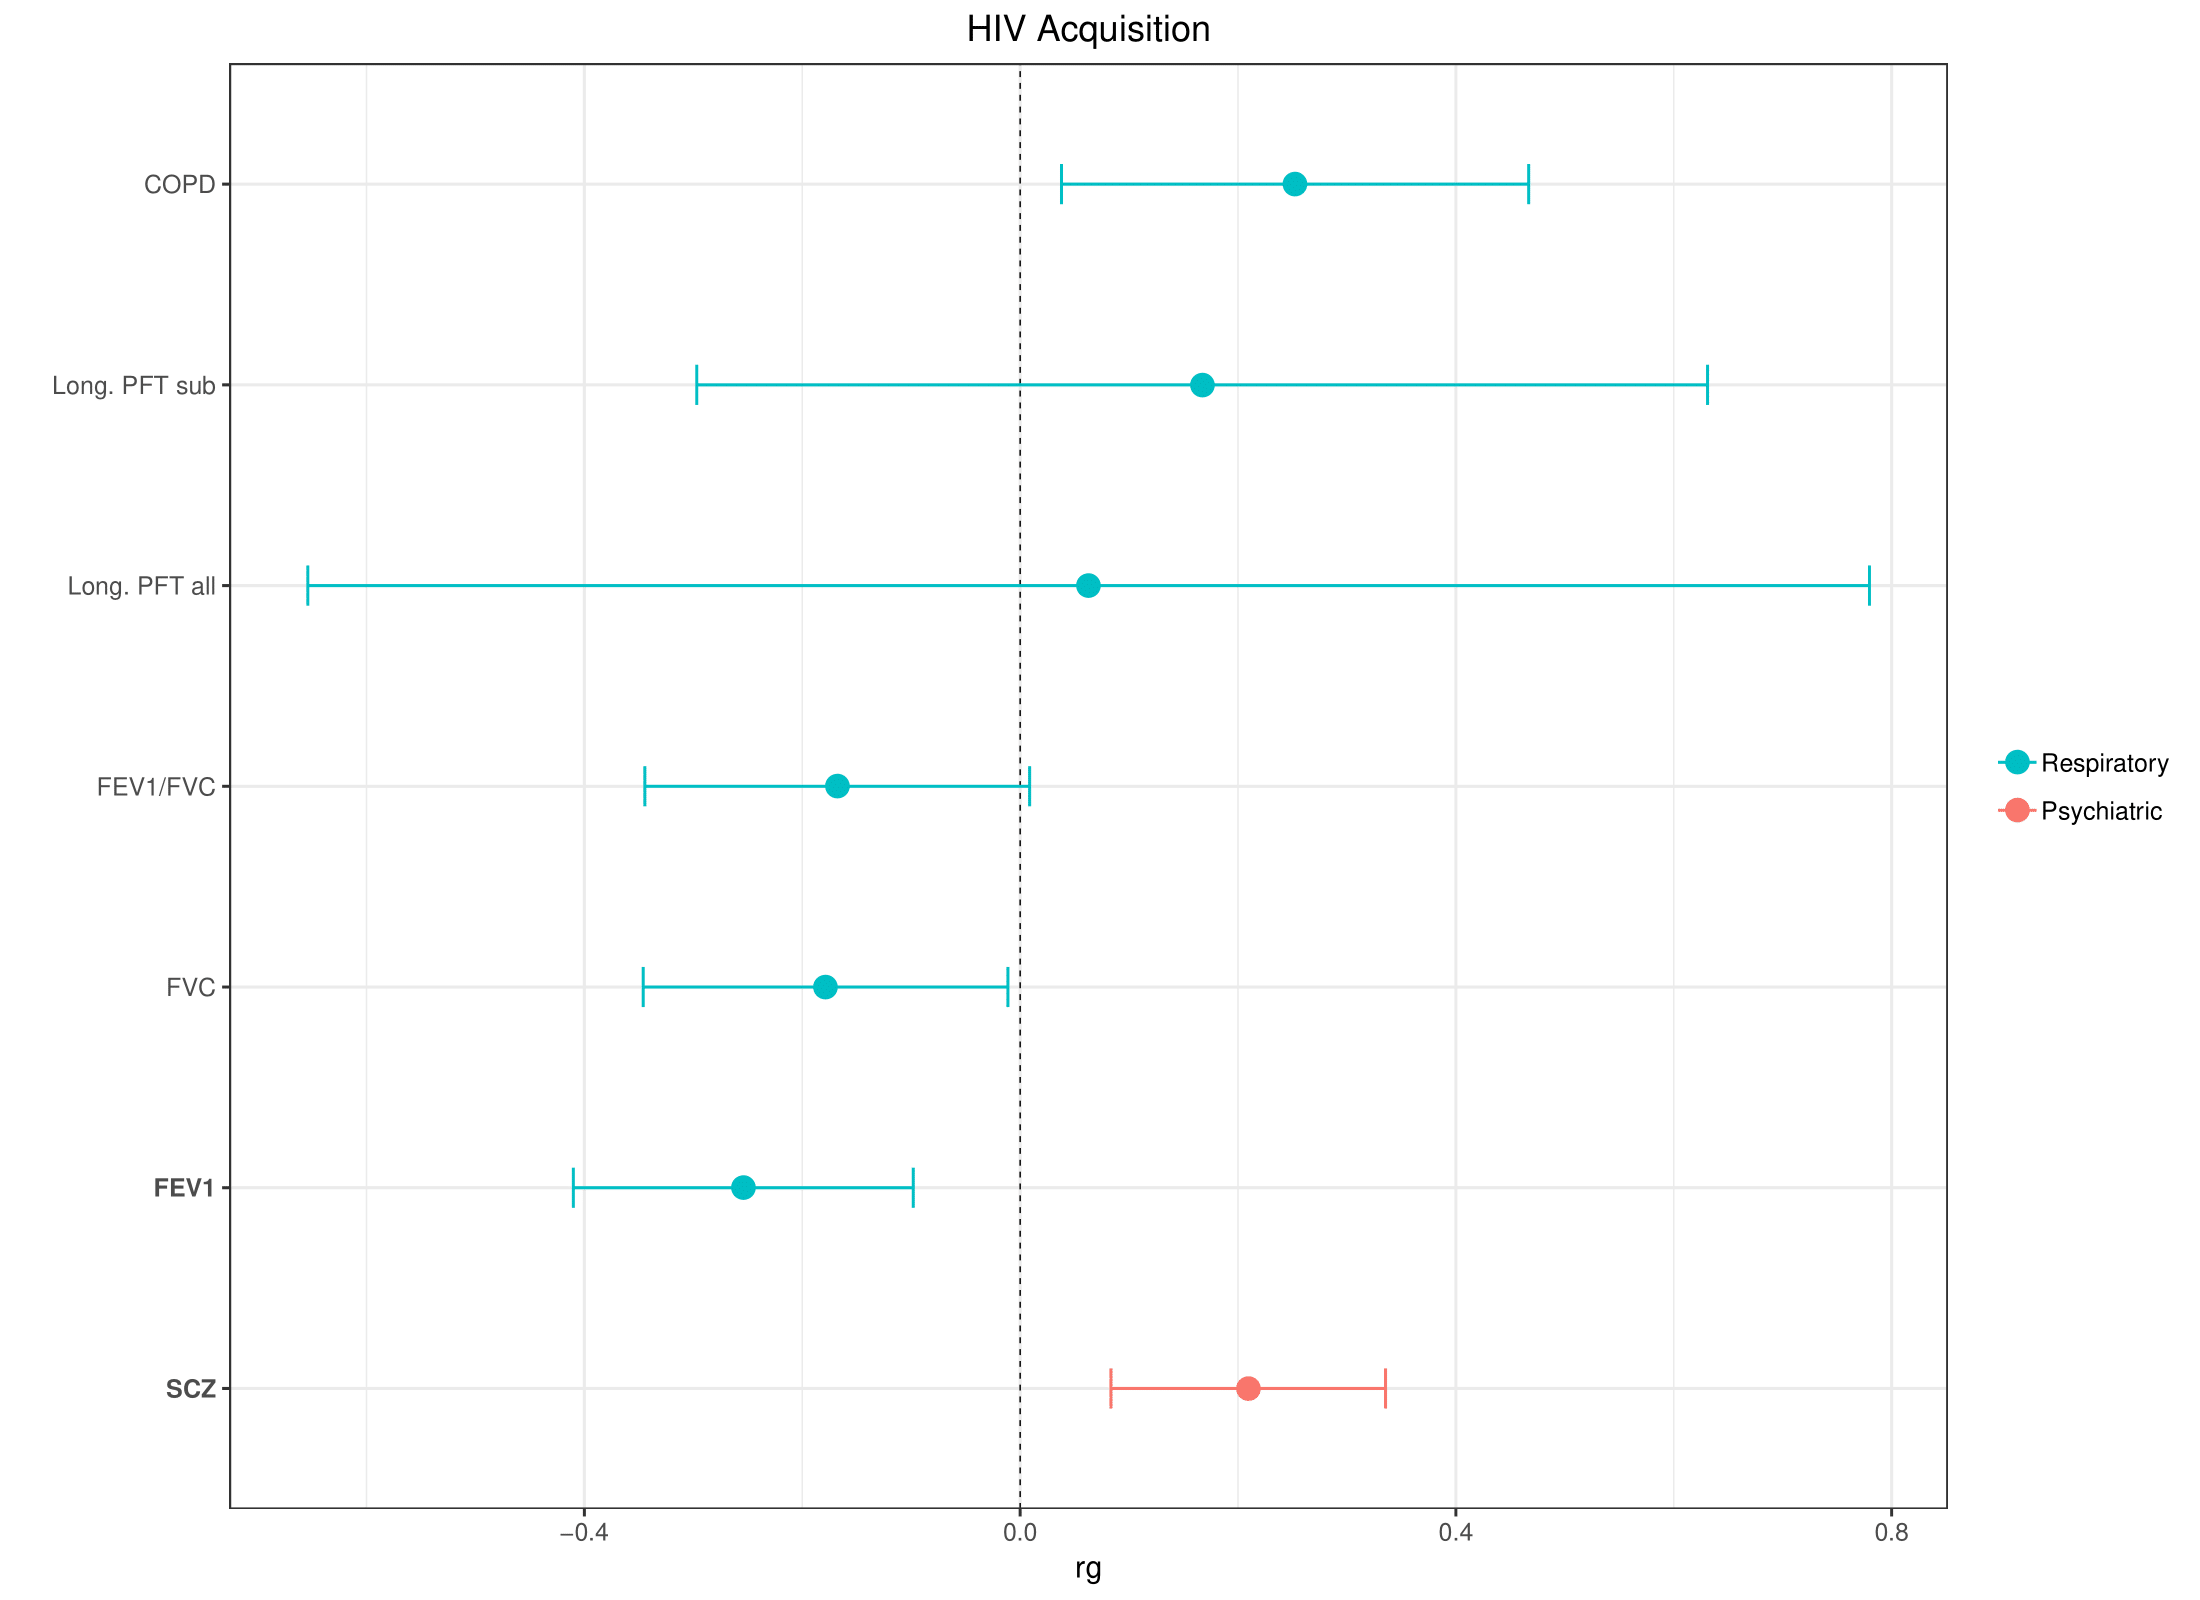

In [7]:
from IPython.display import Image
ldsc = Image(filename='C://Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/ldsc/meta022_copd_pft/v02/final/20190924_hivacq_ldsc_meta022_copd_pft_rg_results-1.png')
display(ldsc)